## K-means: Evaluating clusters on Heart Disease dataset 

This database contains 76 attributes, but all published experiments refer to using a subset of 14 of them. In particular, the Cleveland database is the only one that has been used by ML researchers to this date. The "goal" field refers to the presence of heart disease in the patient. It is integer valued from 0 (no presence) to 4. Experiments with the Cleveland database have concentrated on simply attempting to distinguish presence (values 1,2,3,4) from absence (value 0). 

The 14 attributes used in the below dataset include: 
* **0 = (age)**
* **1 = (sex)** 
* **2 = (cp)**
* **3 = (trestbps)**
* **4 = (chol)** 
* **5 = (fbs)** 
* **6 = (restecg)** 
* **7 = (thalach)**
* **8 = (exang)** 
* **9 = (oldpeak)** 
* **10 = (slope)**
* **11 = (ca)** 
* **12 = (thal)** 
* **13 = (the predicted attribute)**

In [14]:
# Import libraries:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.decomposition import PCA
from sqlalchemy import create_engine

In [2]:
# Establish database connection:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'heartdisease'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
df = pd.read_sql_query('select * from heartdisease',con=engine)

# no need for an open connection, as we're only doing a single query:
engine.dispose()

In [3]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [9]:
# Make sure the number of rows divides evenly into four samples.
rows =df.shape[0] - df.shape[0] % 2
df = df.iloc[:rows, :]

# Break into a set of features and a variable for the known outcome.
X = df.iloc[:, :13]
y = df.iloc[:, 13]

# Replace some random string values.
X = X.replace(to_replace='?', value=0)

# Binarize y so that 1 means heart disease diagnosis and 0 means no diagnosis.
y = np.where(y > 0, 0, 1)

# Normalize
X_std = StandardScaler().fit_transform(X)

# Data frame to store features and predicted cluster memberships.
ypred = pd.DataFrame()

# Create the two-feature PCA for graphing purposes.
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)

# Split the data into four equally-sized samples. First we break it in half:
X_half1, X_half2, X_pcahalf1, X_pcahalf2 = train_test_split(
    X_std,
    X_pca,
    test_size=0.5,
    random_state=123)

# Pass a list of tuples and a counter that increments each time we go
# through the loop. The tuples are the data to be used by k-means,
# and the PCA-derived features for graphing. We use k-means to fit a
# model to the data, then store the predicted values and the two-feature
# PCA solution in the data frame.
for counter, data in enumerate([
    (X_half1, X_pcahalf1),
    (X_half2, X_pcahalf2)]):
    
    # Put the features into ypred.
    ypred['pca_f1' + '_sample' + str(counter)] = data[1][:, 0]
    ypred['pca_f2' + '_sample' + str(counter)] = data[1][:, 1]
    
    # Generate cluster predictions and store them for clusters 2 to 4.
    for nclust in range(2, 5):
        pred = KMeans(n_clusters=nclust, random_state=123).fit_predict(data[0])
        ypred['clust' + str(nclust) + '_sample' + str(counter)] = pred

In [11]:
ypred.head()

,pca_f1_sample0,pca_f2_sample0,clust2_sample0,clust3_sample0,clust4_sample0,pca_f1_sample1,pca_f2_sample1,clust2_sample1,clust3_sample1,clust4_sample1
0,2.897494,1.687819,1,0,2,-0.680053,1.865677,0,0,3
1,1.069871,-0.930562,1,0,2,-1.837344,1.678534,0,0,3
2,0.213718,0.368487,0,2,1,-1.452831,-1.295585,0,2,2
3,-2.023914,-1.187426,0,2,0,1.105467,-0.348884,1,1,0
4,-0.134691,2.415747,0,1,3,-1.626632,1.823312,0,0,3


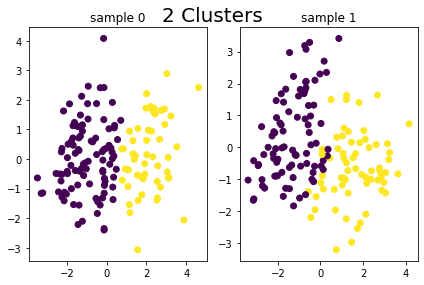

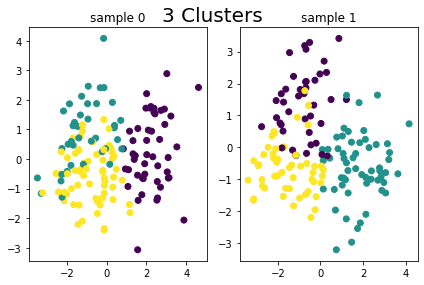

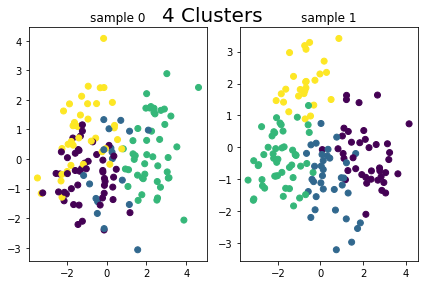

In [12]:
# For each  number of clusters, plot the clusters using the
# pca features for each sample.
for cluster in range(2, 5):
    
    # Make a grid of subplots.
    f, axarr = plt.subplots(1, 2)
    
    # Make a plot for each sample.
    for i in range(2):
        
        # PCA-created features.
        x_sub = ypred['pca_f1_sample{}'.format(i)]
        y_sub = ypred['pca_f2_sample{}'.format(i)]
        
        # Cluster assignments.
        c = ypred['clust{}_sample{}'.format(cluster, i)]
        
        # Assign the subplot to its place on the grid.
        axarr[i].scatter(x_sub, y_sub, c=c)
        axarr[i].set_title('sample {}'.format(i))
        axarr[i].set_xlim()
        axarr[i].set_ylim()
    
    # Space out the plots so that the headings don't overlap axis values.
    plt.suptitle('{} Clusters'.format(cluster), fontsize=20)
    plt.tight_layout()
    plt.show()

As we can see, the three and four cluster solutions seem to miss classify a lot of observations. It looks like the two cluster solution seems to be the only consistent solution among all.

In [15]:
# Evaluate different K-means models with Adjusted_rand_score
pred_2 = KMeans(n_clusters=2, random_state=123).fit_predict(X_std)
pred_3 = KMeans(n_clusters=3, random_state=123).fit_predict(X_std)
pred_4 = KMeans(n_clusters=4, random_state=123).fit_predict(X_std)

print("ARI for two cluster k-means: {}".format(metrics.adjusted_rand_score(y, pred_2)))
print("ARI for three cluster k-means: {}".format(metrics.adjusted_rand_score(y, pred_3)))
print("ARI for four cluster k-means: {}".format(metrics.adjusted_rand_score(y, pred_4)))

ARI for two cluster k-means: 0.43661540614807665
ARI for three cluster k-means: 0.280694132678885
ARI for four cluster k-means: 0.19162596502170298


According to the results, the best solution is the two cluster solution as its ARI score is the highest.

In [16]:
# Evaluate different K-means models using Silhouette score:
pred_2 = KMeans(n_clusters=2, random_state=123).fit_predict(X_std)
pred_3 = KMeans(n_clusters=3, random_state=123).fit_predict(X_std)
pred_4 = KMeans(n_clusters=4, random_state=123).fit_predict(X_std)

print("Silhouette score for two cluster k-means: {}".format(
    metrics.silhouette_score(X_std, pred_2, metric='euclidean')))
print("Silhouette score for three cluster k-means: {}".format(
    metrics.silhouette_score(X_std, pred_3, metric='euclidean')))
print("Silhouette score for four cluster k-means: {}".format(
    metrics.silhouette_score(X_std, pred_4, metric='euclidean')))

Silhouette score for two cluster k-means: 0.17440650461256255
Silhouette score for three cluster k-means: 0.1286219070218783
Silhouette score for four cluster k-means: 0.1314736248593191


Silhouette score also confirms that 2-cluster K-means is the best solution for this dataset.